<a href="https://colab.research.google.com/github/crispitagorico/Neural-SPDEs/blob/main/Parabolic1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/crispitagorico/Neural-SPDEs.git"

Cloning into 'Neural-SPDEs'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 30 (delta 9), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [1]:
%cd Neural-SPDEs/

/content/Neural-SPDEs


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.optim as optim

from utilities import MatReader, LpLoss, count_params
from neuralSPDE_1D import NeuralFixedPoint

torch.manual_seed(0)
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
reader = MatReader('../drive/MyDrive/parabolic_multiplicative.mat')
xi = reader.read_field('forcing')
data = reader.read_field('sol')

In [50]:
ntrain = 800
ntest = 200

batch_size = 20
epochs = 500
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5
step = 1

sub_t = 1

u0_train = data[:ntrain,:-1,0][:,None,...]
u_train = data[:ntrain,:-1,0:50:sub_t][...,-1]
xi_train = xi[:ntrain, :-1, 0:50:sub_t][:,None,...]
xi_train = torch.cat([xi_train,torch.ones_like(xi_train)],dim=1)

u0_test = data[-ntest:,:-1,0][:,None,...]
u_test = data[-ntest:,:-1,0:50:sub_t][...,-1]
xi_test = xi[-ntest:, :-1, 0:50:sub_t][:,None,...]
xi_test = torch.cat([xi_test,torch.ones_like(xi_test)],dim=1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u0_train, xi_train, u_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u0_test, xi_test, u_test), batch_size=batch_size, shuffle=False)

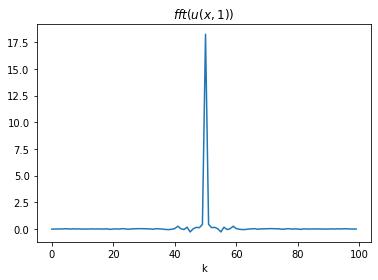

In [51]:
x_ft = torch.fft.fftshift(torch.fft.fftn(u_train[0],dim=0),dim=0)
plt.plot(x_ft)
plt.title(r'$fft({u}(x,1))$')
plt.xlabel('k')
plt.show()

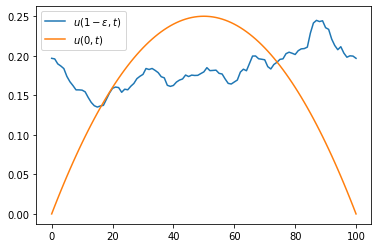

In [52]:
plt.plot(data[0,:,0:50:sub_t][...,-1],label=r'$u(1-\epsilon,t)$')
plt.plot(data[0,:,0:50:sub_t][...,0],label=r'$u(0,t)$')
plt.legend()
plt.show()

In [56]:
# model = NeuralFixedPoint(modes1=16, modes2=16, modes3=8, in_channels=1, hidden_channels=64, forcing_channels=1, out_channels=1, T=T, n_iter=4).cuda()
model = NeuralFixedPoint(modes1=24, modes2=10, in_channels=1, hidden_channels=2, forcing_channels=2, out_channels=1, T=xi_train.shape[3], n_iter=1).cuda()

print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0025, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

1497


In [57]:
myloss = LpLoss(size_average=False)

for ep in range(epochs):

    model.train()
    
    train_loss = 0.
    for u0_, xi_, u_ in train_loader:

        loss = 0.

        u0_ = u0_.to(device)
        xi_ = xi_.to(device)
        u_ = u_.to(device)

        u_pred = model(u0_, xi_)

        loss = myloss(u_pred[...,-1].reshape(batch_size, -1), u_.reshape(batch_size, -1))

        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    
    test_loss = 0.
    with torch.no_grad():
        for u0_, xi_, u_ in test_loader:
            
            loss = 0.
            
            u0_ = u0_.to(device)
            xi_ = xi_.to(device)
            u_ = u_.to(device)

            u_pred = model(u0_, xi_)

            loss = myloss(u_pred[...,-1].reshape(batch_size, -1), u_.reshape(batch_size, -1))

            test_loss += loss.item()

    scheduler.step()
    if ep%20==0:
      print('Epoch {:04d} | Total Train Loss {:.6f} | Total Test Loss {:.6f}'.format(ep, train_loss / ntrain, test_loss / ntest))
    

Epoch 0000 | Total Train Loss 0.336493 | Total Test Loss 0.254556
Epoch 0020 | Total Train Loss 0.076107 | Total Test Loss 0.073861
Epoch 0040 | Total Train Loss 0.073364 | Total Test Loss 0.067019
Epoch 0060 | Total Train Loss 0.061365 | Total Test Loss 0.062686
Epoch 0080 | Total Train Loss 0.061866 | Total Test Loss 0.078980
Epoch 0100 | Total Train Loss 0.058638 | Total Test Loss 0.056005
Epoch 0120 | Total Train Loss 0.054017 | Total Test Loss 0.056252
Epoch 0140 | Total Train Loss 0.059698 | Total Test Loss 0.059572
Epoch 0160 | Total Train Loss 0.059333 | Total Test Loss 0.059265
Epoch 0180 | Total Train Loss 0.053886 | Total Test Loss 0.057203
Epoch 0200 | Total Train Loss 0.051984 | Total Test Loss 0.056026
Epoch 0220 | Total Train Loss 0.053903 | Total Test Loss 0.053086
Epoch 0240 | Total Train Loss 0.051317 | Total Test Loss 0.056137
Epoch 0260 | Total Train Loss 0.051847 | Total Test Loss 0.052589
Epoch 0280 | Total Train Loss 0.051288 | Total Test Loss 0.051464
Epoch 0300

**Visualize results**

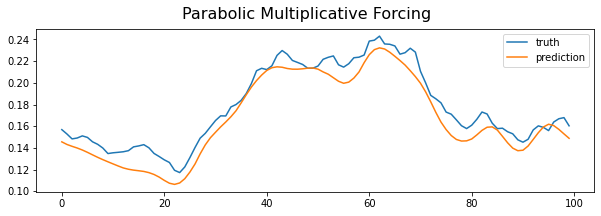

In [59]:
k = 2
T_= 1

# u0 = u0_train[k][None,...].to(device)
# u = u_train[k][None,...].to(device) 
# xi = xi_train[k][None,...].to(device)
u0 = u0_test[k][None,...].to(device)
u = u_test[k][None,...].to(device) 
xi = xi_test[k][None,...].to(device)
u_pred = model(u0,xi)

# fig, ax = plt.subplots(1,T_+1,figsize=(25,3))
fig = plt.figure(figsize=(10,3))
plt.suptitle('Parabolic Multiplicative Forcing', fontsize=16)

# ax[0].plot(u0[0,0,...].detach().cpu().numpy())
# ax[0].set_title('initial condition')

# for i in range(T_):
#   ax[i+1].plot(u[0,...,i].detach().cpu().numpy())
#   ax[i+1].plot(u_pred[0,0,...,i].detach().cpu().numpy())
 # # ax[0][i+1].set_title(f'time step {i+1}')
plt.plot(u[0].detach().cpu().numpy(),label='truth')
plt.plot(u_pred[0,0,...,-1].detach().cpu().numpy(),label='prediction')
plt.legend()
# plt.tight_layout()
plt.show()